In [1]:
%matplotlib inline
import sys
import time

from concurrent.futures import ProcessPoolExecutor

import numpy as np
import seaborn as sns
import pandas as pd
import xgboost as xgb
import cv2
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from numpy.linalg import norm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import features

from dataset import read_datasets, read_leap_motion_data
from features import extract_features, extract_lp_features, hog_single
from train import precision_for, train_clf, feature_precisions, predict_img
from utils import print_log, set_cache, get_cache

%reload_ext autoreload
%autoreload 2

c:\users\wujie\appdata\local\programs\python\python35\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Dataset Load
persons = read_leap_motion_data('LP_data/dataset', load_cache=True)

LP_data/dataset\P1\G1
LP_data/dataset\P1\G10
LP_data/dataset\P1\G2
LP_data/dataset\P1\G3
LP_data/dataset\P1\G4
LP_data/dataset\P1\G5
LP_data/dataset\P1\G6
LP_data/dataset\P1\G7
LP_data/dataset\P1\G8
LP_data/dataset\P1\G9
LP_data/dataset\P10\G1
LP_data/dataset\P10\G10
LP_data/dataset\P10\G2
LP_data/dataset\P10\G3
LP_data/dataset\P10\G4
LP_data/dataset\P10\G5
LP_data/dataset\P10\G6
LP_data/dataset\P10\G7
LP_data/dataset\P10\G8
LP_data/dataset\P10\G9
LP_data/dataset\P11\G1
LP_data/dataset\P11\G10
LP_data/dataset\P11\G2
LP_data/dataset\P11\G3
LP_data/dataset\P11\G4
LP_data/dataset\P11\G5
LP_data/dataset\P11\G6
LP_data/dataset\P11\G7
LP_data/dataset\P11\G8
LP_data/dataset\P11\G9
LP_data/dataset\P12\G1
LP_data/dataset\P12\G10
LP_data/dataset\P12\G2
LP_data/dataset\P12\G3
LP_data/dataset\P12\G4
LP_data/dataset\P12\G5
LP_data/dataset\P12\G6
LP_data/dataset\P12\G7
LP_data/dataset\P12\G8
LP_data/dataset\P12\G9
LP_data/dataset\P13\G1
LP_data/dataset\P13\G10
LP_data/dataset\P13\G2
LP_data/dataset\

In [3]:
# Feature Extraction
X = []
y = []
X_limg = []
X_rimg = []
indices = []
for p in persons:
    print('Processing {}'.format(p))
    for g_idx in range(1, 11):
        for idx in range(1, 21):
            g = 'G{}'.format(g_idx)
            d = persons[p][g][idx]
            if not d:
                continue
            X_limg.append(hog_single(d['leye']))
            X_rimg.append(hog_single(d['reye']))
            f = extract_lp_features(d['json'])
            X.append(f)
            y.append(g_idx-1)
            indices.append((p, g, idx))
X = np.array(X)
y = np.array(y)
max_dist = np.max(X[:, 5:10])
X[:, 5:] = X[:, 5:] / max_dist

all_data = pd.DataFrame(np.append(X, y.reshape((-1, 1)), axis=1))
all_data.to_csv('caches/feature_set.csv', index=False, float_format='%.3f')
all_data

Processing P12
Processing P8
Processing P1
Processing P13
Processing P6
Processing P7
Processing P11
Processing P4
Processing P5
Processing P9
Processing P10
Processing P3
Processing P2


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
1,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
2,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
3,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
4,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
5,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
6,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
7,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
8,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
9,0.816387,0.000000,0.00000,0.000000,0.000000,0.208997,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0


In [4]:
s = time.time()
hog_single(persons['P2']['G9'][5]['leye'])
e = time.time()
print('{:.4f} s'.format(e-s))

0.0160 s


In [5]:
X_train, X_test, X_limg_train, X_limg_test, X_rimg_train, X_rimg_test, y_train, y_test = train_test_split(
    X, X_limg, X_rimg, y, test_size=0.2)

In [6]:
# Train Best clf for numerical data
features_selection = features.F_A | features.F_D | features.F_T | features.F_E
clf = train_clf(X_train, y_train, features_selection, test_size=0.2, ITER_TIMES=150,
                params={'max_depth': 6})
deletes = []
if not (features_selection & features.F_T):
    deletes.extend(range(15, 25))
if not (features_selection & features.F_E):
    deletes.extend(range(10, 15))
if not (features_selection & features.F_D):
    deletes.extend(range(5, 10))
if not (features_selection & features.F_A):
    deletes.extend(range(0, 5))       
A = np.delete(X_train, deletes, axis=1)
h_numerical = clf.predict(xgb.DMatrix(A))
A = np.delete(X_test, deletes, axis=1)
h_numerical_test = clf.predict(xgb.DMatrix(A))

set_cache(clf, 'prfediction_model')


Accuracy on numerical train set : 97.84%
Accuracy on numerical test set  : 89.23%


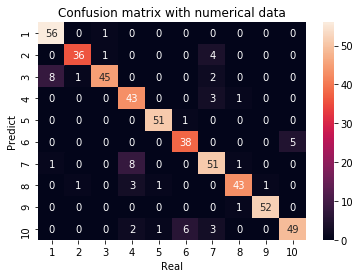

In [7]:
num_confusion_mat = np.zeros((10, 10))
for i, j in zip(y_test, h_numerical_test.astype(int)):
    num_confusion_mat[i][j] += 1
sns.heatmap(num_confusion_mat, annot=True, xticklabels=range(1, 11), yticklabels=range(1, 11))
plt.xlabel('Real')
plt.ylabel('Predict')
plt.title('Confusion matrix with numerical data')
print()
print('Accuracy on numerical train set : {:.2%}'.format(accuracy_score(h_numerical, y_train)))
print('Accuracy on numerical test set  : {:.2%}'.format(accuracy_score(h_numerical_test, y_test)))

In [8]:
A = np.delete(X, deletes, axis=1)
h_all = clf.predict(xgb.DMatrix(A))
print('Accuracy on numerical set: {:.2%}'.format(accuracy_score(h_all, y)))

Accuracy on numerical set: 96.12%


In [9]:
# xgboost for pixel data
best_clf = None
best_accuracy = 0
for i in range(10):
    X_ltrain_h, X_ltest_h, X_rtrain_h, X_rtest_h, y_train_h, y_test_h = train_test_split(X_limg_train, X_rimg_train, y_train, test_size=0.15)
    X_train_h = np.append(np.array(X_ltrain_h), np.array(X_rtrain_h), axis=1)
    X_test_h = np.append(np.array(X_ltest_h), np.array(X_rtest_h), axis=1)
    dtrain = xgb.DMatrix(X_train_h, label=y_train_h)
    dtest = xgb.DMatrix(X_test_h, label=y_test_h)
    watchlist = [(dtrain, 'train'), (dtest, 'test')]
    params = {'max_de pth': 2, 'eta': 1, 'silent': 1, 'objective': 'multi:softmax', 'num_class': 10}
    num_round = 100
    bst = xgb.train(params, dtrain, num_round)
    preds = bst.predict(dtest)
    accuracy = np.sum(preds == y_test_h) / len(y_test_h)
    if accuracy > best_accuracy:
        best_clf = bst
        best_accuracy = accuracy
    print('Round {:3d} Accuracy: {:7.2%}'.format(i+1, accuracy))
print('Best accuracy on CV set: {:7.2%}'.format(best_accuracy))

Round   1 Accuracy:  90.38%
Round   2 Accuracy:  89.10%
Round   3 Accuracy:  92.63%
Round   4 Accuracy:  89.42%
Round   5 Accuracy:  91.99%
Round   6 Accuracy:  92.63%
Round   7 Accuracy:  90.38%
Round   8 Accuracy:  91.03%
Round   9 Accuracy:  92.63%
Round  10 Accuracy:  95.51%
Best accuracy on CV set:  95.51%


In [10]:
dtrain = xgb.DMatrix(np.append(np.array(X_limg_train), np.array(X_rimg_train), axis=1))
dtest = xgb.DMatrix(np.append(np.array(X_limg_test), np.array(X_rimg_test), axis=1))
h_img = best_clf.predict(dtrain)
h_img_test = best_clf.predict(dtest)


Accuracy on pixel train set : 99.33%
Accuracy on pixel test set  : 89.04%


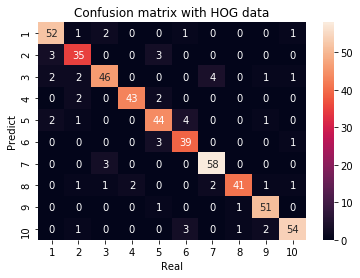

In [11]:
hog_confusion_mat = np.zeros((10, 10))
for i, j in zip(y_test, h_img_test.astype(int)):
    hog_confusion_mat[i][j] += 1
sns.heatmap(hog_confusion_mat, annot=True, xticklabels=range(1, 11), yticklabels=range(1, 11))
plt.xlabel('Real')
plt.ylabel('Predict')
plt.title('Confusion matrix with HOG data')
print()
print('Accuracy on pixel train set : {:.2%}'.format(accuracy_score(h_img, y_train)))
print('Accuracy on pixel test set  : {:.2%}'.format(accuracy_score(h_img_test, y_test)))

In [12]:
# Combine prediction for numerical data and prediction for pixel data
hn_train = np.array(h_numerical).reshape(-1, 1)
hi_train = np.array(h_img).reshape(-1, 1)
hc_train = np.append(hn_train, hi_train, axis=1)

hn_test = np.array(h_numerical_test).reshape(-1, 1)
hi_test = np.array(h_img_test).reshape(-1, 1)
hc_test = np.append(hn_test, hi_test, axis=1)


dtrain = xgb.DMatrix(hc_train, label=y_train)
dtest = xgb.DMatrix(hc_test, label=y_test)
# specify parameters via map
params = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'multi:softmax', 'num_class': 10}
num_round = 100
watch_list = [(dtrain, 'train'), (dtest, 'test')]
clf_combine = xgb.train(params, dtrain, num_round, watch_list)
h_combine = clf_combine.predict(dtest)
print('Combined predictions accuracy on test set : {:.2%}'.format(accuracy_score(h_combine, y_test)))

[0]	train-merror:0.007212	test-merror:0.109615
[1]	train-merror:0.00625	test-merror:0.101923
[2]	train-merror:0.005769	test-merror:0.101923
[3]	train-merror:0.005769	test-merror:0.109615
[4]	train-merror:0.005288	test-merror:0.107692
[5]	train-merror:0.003846	test-merror:0.105769
[6]	train-merror:0.002885	test-merror:0.098077
[7]	train-merror:0.002885	test-merror:0.098077
[8]	train-merror:0.002885	test-merror:0.098077
[9]	train-merror:0.002885	test-merror:0.096154
[10]	train-merror:0.002885	test-merror:0.096154
[11]	train-merror:0.002885	test-merror:0.096154
[12]	train-merror:0.002885	test-merror:0.088462
[13]	train-merror:0.002404	test-merror:0.096154
[14]	train-merror:0.002885	test-merror:0.088462
[15]	train-merror:0.002404	test-merror:0.088462
[16]	train-merror:0.002404	test-merror:0.096154
[17]	train-merror:0.002404	test-merror:0.096154
[18]	train-merror:0.002404	test-merror:0.086538
[19]	train-merror:0.002404	test-merror:0.090385
[20]	train-merror:0.002404	test-merror:0.082692
[21

In [13]:
print('Accuracy on numerical train set : {:.2%}'.format(accuracy_score(h_numerical, y_train)))
print('Accuracy on numerical test set  : {:.2%}'.format(accuracy_score(h_numerical_test, y_test)))
print('Accuracy on HOG train set       : {:.2%}'.format(accuracy_score(h_img, y_train)))  
print('Accuracy on HOG test set        : {:.2%}'.format(accuracy_score(h_img_test, y_test)))
print('Accuracy on combined test set   : {:.2%}'.format(accuracy_score(h_combine, y_test)))

Accuracy on numerical train set : 97.84%
Accuracy on numerical test set  : 89.23%
Accuracy on HOG train set       : 99.33%
Accuracy on HOG test set        : 89.04%
Accuracy on combined test set   : 91.73%


In [14]:
# Combine numerical data and pixel data
Xnum_train = np.array(X_train)
Ximg_train = np.append(np.array(X_limg_train), np.array(X_rimg_train), axis=1)
Xc_train = np.append(Xnum_train, Ximg_train, axis=1)

Xnum_test = np.array(X_test)
Ximg_test = np.append(np.array(X_limg_test), np.array(X_rimg_test), axis=1)
Xc_test = np.append(Xnum_test, Ximg_test, axis=1)

In [15]:
res = []
for p in range(100, 69, -1):
    percent = p / 100
    if abs(percent - 1) < 1e-5:
        DECOMPOSITION = False
    else:
        DECOMPOSITION = True
    pca = PCA(percent)

    # Train set
    data = Xc_train
    if DECOMPOSITION:
        data = pca.fit_transform(data)
    if res and data.shape[1] == res[-1][1]:
        continue
    dtrain = xgb.DMatrix(data, label=y_train)
    
    # Test set
    data = Xc_test
    if DECOMPOSITION:
        data = pca.transform(data)
    dtest = xgb.DMatrix(data, label=y_test)

    params = {'max_depth': 6, 'eta': 0.1, 'silent':1, 'objective':'multi:softmax',
             'num_class': 10}
    num_round = 200
    watch_list = [(dtrain, 'train'), (dtest, 'test')]
    clf_combine = xgb.train(params, dtrain, num_round)
    h_combine = clf_combine.predict(dtest)
    _res = (percent, data.shape[1], accuracy_score(h_combine, y_test))
    res.append(_res)
    print('Variance retained: {:7.2%}, Dimensions retained: {:6d}, Accuracy: {:7.2%}'.format(*_res))

Variance retained: 100.00%, Dimensions retained:  14137, Accuracy:  97.12%
Variance retained:  99.00%, Dimensions retained:    287, Accuracy:  93.85%
Variance retained:  98.00%, Dimensions retained:    196, Accuracy:  94.04%
Variance retained:  97.00%, Dimensions retained:    147, Accuracy:  93.65%
Variance retained:  96.00%, Dimensions retained:    116, Accuracy:  94.23%
Variance retained:  95.00%, Dimensions retained:     95, Accuracy:  94.04%
Variance retained:  94.00%, Dimensions retained:     79, Accuracy:  93.85%
Variance retained:  93.00%, Dimensions retained:     67, Accuracy:  94.23%
Variance retained:  92.00%, Dimensions retained:     58, Accuracy:  93.27%
Variance retained:  91.00%, Dimensions retained:     51, Accuracy:  93.46%
Variance retained:  90.00%, Dimensions retained:     45, Accuracy:  93.27%
Variance retained:  89.00%, Dimensions retained:     40, Accuracy:  93.27%
Variance retained:  88.00%, Dimensions retained:     36, Accuracy:  92.88%
Variance retained:  87.00

Max:   97.12%


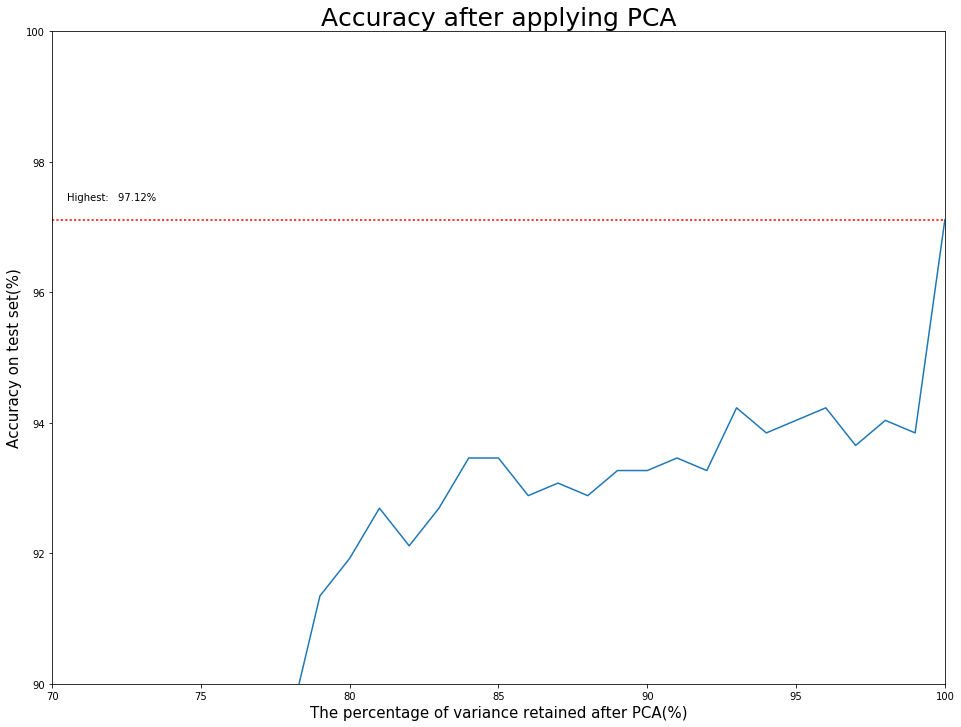

In [16]:
rres = [(k[0]*100, k[2]*100) for k in res]
rres_x = [k[0] for k in rres]
rres_y = [k[1] for k in rres]

highest_accuracy = max(rres_y)
print('Max: {:7.2f}%'.format(highest_accuracy))
      
plt.figure(figsize=(16, 12))
plt.plot(rres_x, rres_y)
plt.xlabel('The percentage of variance retained after PCA(%)', fontsize=15)
plt.ylabel('Accuracy on test set(%)', fontsize=15)
plt.ylim((90, 100))
plt.xlim((70, 100))
plt.axhline(y=highest_accuracy, xmin=0, xmax=100, color='r', linestyle='dotted')
plt.text(70.5, highest_accuracy+0.3, 'Highest: {:7.2f}%'.format(highest_accuracy))
plt.title('Accuracy after applying PCA', fontsize=25)

In [17]:
dtrain = xgb.DMatrix(Xc_train, label=y_train)
dtest = xgb.DMatrix(Xc_test, label=y_test)
# pca = PCA(0.87)
# dtrain = xgb.DMatrix(pca.fit_transform(Xc_train), label=y_train)
# dtest = xgb.DMatrix(pca.transform(Xc_test), label=y_test)

params = {'max_depth': 6, 'eta': 0.1, 'silent':1, 'objective':'multi:softmax',
          'num_class': 10, 'subsample': 0.6, 'gamma': 0}
num_round = 2000
evals = [(dtrain, 'train'), (dtest, 'test')]

clf_combine = xgb.train(params, dtrain, num_round, evals, early_stopping_rounds=300)
h_combine = clf_combine.predict(dtrain).astype(int)
h_combine_test = clf_combine.predict(dtest).astype(int)

[0]	train-merror:0.097115	test-merror:0.188462
Multiple eval metrics have been passed: 'test-merror' will be used for early stopping.

Will train until test-merror hasn't improved in 300 rounds.
[1]	train-merror:0.060096	test-merror:0.159615
[2]	train-merror:0.045673	test-merror:0.134615
[3]	train-merror:0.037019	test-merror:0.123077
[4]	train-merror:0.030769	test-merror:0.109615
[5]	train-merror:0.026923	test-merror:0.101923
[6]	train-merror:0.022115	test-merror:0.088462
[7]	train-merror:0.019231	test-merror:0.086538
[8]	train-merror:0.016827	test-merror:0.086538
[9]	train-merror:0.015385	test-merror:0.080769
[10]	train-merror:0.014904	test-merror:0.078846
[11]	train-merror:0.0125	test-merror:0.076923
[12]	train-merror:0.012019	test-merror:0.075
[13]	train-merror:0.010577	test-merror:0.075
[14]	train-merror:0.010096	test-merror:0.073077
[15]	train-merror:0.009615	test-merror:0.073077
[16]	train-merror:0.009135	test-merror:0.073077
[17]	train-merror:0.008654	test-merror:0.073077
[18]	t

[186]	train-merror:0	test-merror:0.028846
[187]	train-merror:0	test-merror:0.028846
[188]	train-merror:0	test-merror:0.028846
[189]	train-merror:0	test-merror:0.028846
[190]	train-merror:0	test-merror:0.028846
[191]	train-merror:0	test-merror:0.028846
[192]	train-merror:0	test-merror:0.028846
[193]	train-merror:0	test-merror:0.028846
[194]	train-merror:0	test-merror:0.028846
[195]	train-merror:0	test-merror:0.028846
[196]	train-merror:0	test-merror:0.028846
[197]	train-merror:0	test-merror:0.028846
[198]	train-merror:0	test-merror:0.028846
[199]	train-merror:0	test-merror:0.028846
[200]	train-merror:0	test-merror:0.028846
[201]	train-merror:0	test-merror:0.028846
[202]	train-merror:0	test-merror:0.028846
[203]	train-merror:0	test-merror:0.028846
[204]	train-merror:0	test-merror:0.028846
[205]	train-merror:0	test-merror:0.028846
[206]	train-merror:0	test-merror:0.028846
[207]	train-merror:0	test-merror:0.028846
[208]	train-merror:0	test-merror:0.028846
[209]	train-merror:0	test-merror:0

[382]	train-merror:0	test-merror:0.030769
[383]	train-merror:0	test-merror:0.030769
[384]	train-merror:0	test-merror:0.030769
[385]	train-merror:0	test-merror:0.030769
[386]	train-merror:0	test-merror:0.030769
[387]	train-merror:0	test-merror:0.030769
[388]	train-merror:0	test-merror:0.030769
[389]	train-merror:0	test-merror:0.030769
[390]	train-merror:0	test-merror:0.030769
[391]	train-merror:0	test-merror:0.030769
[392]	train-merror:0	test-merror:0.030769
[393]	train-merror:0	test-merror:0.030769
[394]	train-merror:0	test-merror:0.030769
[395]	train-merror:0	test-merror:0.030769
[396]	train-merror:0	test-merror:0.030769
[397]	train-merror:0	test-merror:0.030769
[398]	train-merror:0	test-merror:0.030769
[399]	train-merror:0	test-merror:0.030769
[400]	train-merror:0	test-merror:0.030769
[401]	train-merror:0	test-merror:0.030769
[402]	train-merror:0	test-merror:0.030769
[403]	train-merror:0	test-merror:0.030769
[404]	train-merror:0	test-merror:0.030769
[405]	train-merror:0	test-merror:0

In [18]:
x0 = xgb.DMatrix(Xc_train[0:2])
s = time.time()
_h = clf_combine.predict(x0)
e = time.time()
print('{:.4f} s'.format(e-s))

0.0080 s



Combined features accuracy on train set : 100.00%
Combined features accuracy on test set  : 97.12%


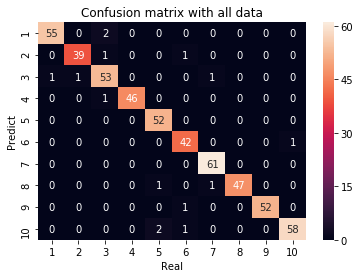

In [19]:
tot_confusion_mat = np.zeros((10, 10))
for i, j in zip(y_test, h_combine_test):
    tot_confusion_mat[i][j] += 1
sns.heatmap(tot_confusion_mat, annot=True, xticklabels=range(1, 11), yticklabels=range(1, 11))
plt.xlabel('Real')
plt.ylabel('Predict')
plt.title('Confusion matrix with all data')
print()
print('Combined features accuracy on train set : {:.2%}'.format(accuracy_score(h_combine, y_train)))
print('Combined features accuracy on test set  : {:.2%}'.format(accuracy_score(h_combine_test, y_test)))

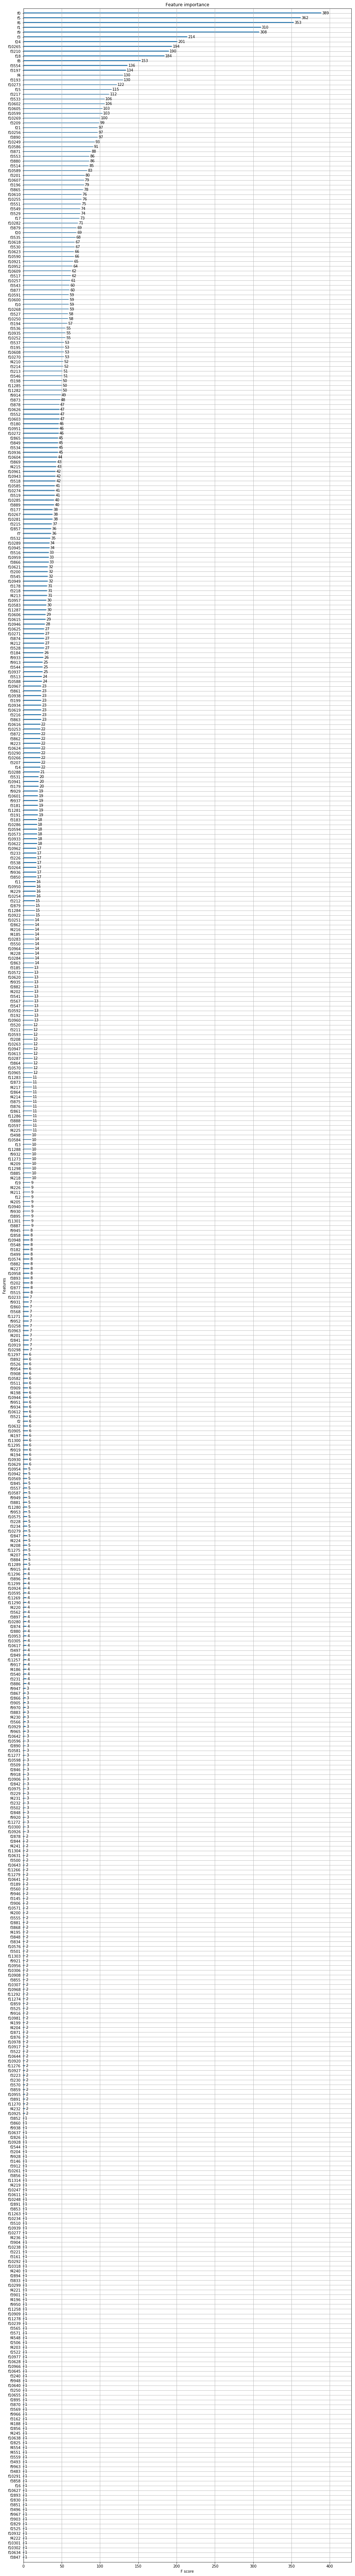

In [20]:
fig = plt.figure(figsize=(16, 128))
ax = fig.add_subplot(1, 1, 1)
xgb.plot_importance(clf_combine, ax)